# **Tercer Parcial Inteligentes II**

# Primer Punto

Entrene un modelo CART o C4.5/ID3 para obtener un árbol de decisión y generar reglas explı́citas de clasiﬁcación. A continuación, analice las reglas obtenidas, identiﬁque cuáles resultan más útiles (por ejemplo, por pureza, cobertura y simplicidad), y realice una validación cruzada del modelo.

In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np

### Carga del Dataset

El dataset **Letter Recognition** se carga directamente desde el repositorio de UCI. Contiene 20,000 instancias y 16 atributos numéricos que representan características estadísticas extraídas de imágenes de las 26 letras mayúsculas del alfabeto.

In [18]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/letter-recognition/letter-recognition.data"
column_names = [
    "letter",
    "x-box",
    "y-box",
    "width",
    "height",
    "onpix",
    "x-bar",
    "y-bar",
    "x2bar",
    "y2bar",
    "xybar",
    "x2ybr",
    "xy2br",
    "x-ege",
    "xegvy",
    "y-ege",
    "yegvx",
]
df = pd.read_csv(url, header=None, names=column_names)
df.head()

,letter,x-box,y-box,width,height,onpix,x-bar,y-bar,x2bar,y2bar,xybar,x2ybr,xy2br,x-ege,xegvy,y-ege,yegvx
0,T,2,8,3,5,1,8,13,0,6,6,10,8,0,8,0,8
1,I,5,12,3,7,2,10,5,5,4,13,3,9,2,8,4,10
2,D,4,11,6,8,6,10,6,2,6,10,3,7,3,7,3,9
3,N,7,11,6,6,3,5,9,4,6,4,4,10,6,10,2,8
4,G,2,1,3,1,1,8,6,6,6,6,5,9,1,7,5,10


## 2. Preparación de Datos

Se dividen los datos en características (`X`) y la variable objetivo (`y`). La columna 'letter' para poder realizar el metodo de clasificación correspondiente. Se procede con la division de los datos en conjuntos de entrenamiento (80%) y prueba (20%) utilizando `train_test_split`. El parámetro `stratify=y` asegura que la proporción de cada clase se mantenga en ambos conjuntos, lo cual es crucial para datasets con muchas clases.

In [19]:
X = df.drop("letter", axis=1)
y = df["letter"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Dimensiones de X_train: {X_train.shape}")
print(f"Dimensiones de X_test: {X_test.shape}")

Dimensiones de X_train: (16000, 16)
Dimensiones de X_test: (4000, 16)


## 3. Entrenamiento del Árbol de Decisión

Se instancia un `DecisionTreeClassifier`. Se utiliza `criterion='entropy'` para que el algoritmo use la **ganancia de información** para decidir las divisiones en cada nodo, siguiendo el principio del algoritmo ID3/C4.5. El modelo se entrena con los datos de `X_train` y `y_train`.

In [20]:
dt_classifier = DecisionTreeClassifier(criterion="entropy", random_state=42)
dt_classifier.fit(X_train, y_train)
y_pred = dt_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy del modelo: {accuracy:.4f}")

Accuracy del modelo: 0.8840


## 4. Evaluación del Modelo

La evaluación del modelo es fundamental para entender su rendimiento. Se utilizan tres enfoques:
1.  **Matriz de Confusión**: Muestra el número de predicciones correctas e incorrectas por clase. Es útil para ver qué letras se confunden entre sí.
2.  **Reporte de Clasificación**: Proporciona métricas detalladas (Precision, Recall, F1-score) para cada una de las 26 clases, permitiendo un análisis granular del rendimiento.
3.  **Validación Cruzada**: Se realiza una validación cruzada de 10 folds (`cv=10`) sobre todo el dataset para obtener una estimación más robusta y menos sesgada del `accuracy` del modelo. Esto ayuda a confirmar que el buen rendimiento no se debe a la división particular de entrenamiento/prueba.

In [21]:
# Matriz de confusión con etiquetas visibles
conf_matrix = confusion_matrix(y_test, y_pred)
conf_df = pd.DataFrame(
    conf_matrix,
    index=[f"Real {cls}" for cls in set(y_test)],
    columns=[f"Pred {cls}" for cls in set(y_test)]
)

print("Matriz de Confusión:")
print(conf_df)

# Reporte en modo tabla
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))

Matriz de Confusión:
        Pred P  Pred N  Pred B  Pred C  Pred Q  Pred W  Pred L  Pred F  \
Real P     151       0       0       0       0       0       2       0   
Real N       0     133       0       1       0       2       2       0   
Real B       0       1     130       0       1       1       7       0   
Real C       1       2       0     136       0       2       2       6   
Real Q       0       0       4       0     134       1       1       0   
Real W       0       1       1       1       0     129       0       3   
Real L       0       0       8       0       3       0     126       1   
Real F       1       2       0       4       0       0       0     121   
Real H       1       1       1       1       0       2       0       1   
Real U       1       1       0       1       0       2       0       0   
Real E       1       0       1       3       0       0       0       3   
Real J       0       0       1       0       2       0       2       0   
Real O       0   

### Validación Cruzada

In [22]:
cv_scores = cross_val_score(dt_classifier, X, y, cv=10)
print("Resultados de la Validación Cruzada (Accuracy por fold):")
print(cv_scores)
print(f"\nAccuracy Promedio (Validación Cruzada): {np.mean(cv_scores):.4f}")
print(f"Desviación Estándar (Validación Cruzada): {np.std(cv_scores):.4f}")

Resultados de la Validación Cruzada (Accuracy por fold):
[0.8995 0.8725 0.8935 0.901  0.888  0.872  0.904  0.8915 0.8905 0.887 ]

Accuracy Promedio (Validación Cruzada): 0.8900
Desviación Estándar (Validación Cruzada): 0.0103


## 5. Análisis del Árbol de Decisión

### Extracción de Reglas

Se utiliza `export_text` para convertir el árbol entrenado en un conjunto de reglas legibles `if-then-else`. Esto permite entender exactamente cómo el modelo toma sus decisiones. Se imprimen las primeras 20 líneas para mostrar la estructura jerárquica de las decisiones.

In [23]:
tree_rules = export_text(dt_classifier, feature_names=list(X.columns))
print("Reglas del Árbol de Decisión (primeros niveles):\n")
for line in tree_rules.split("\n")[:20]:
    print(" • " + line)

Reglas del Árbol de Decisión (primeros niveles):

 • |--- y-ege <= 2.50
 • |   |--- x-ege <= 2.50
 • |   |   |--- y-bar <= 8.50
 • |   |   |   |--- x2ybr <= 3.50
 • |   |   |   |   |--- y2bar <= 3.50
 • |   |   |   |   |   |--- class: A
 • |   |   |   |   |--- y2bar >  3.50
 • |   |   |   |   |   |--- xybar <= 9.50
 • |   |   |   |   |   |   |--- x-ege <= 1.50
 • |   |   |   |   |   |   |   |--- class: L
 • |   |   |   |   |   |   |--- x-ege >  1.50
 • |   |   |   |   |   |   |   |--- class: A
 • |   |   |   |   |   |--- xybar >  9.50
 • |   |   |   |   |   |   |--- x-ege <= 1.50
 • |   |   |   |   |   |   |   |--- yegvx <= 8.50
 • |   |   |   |   |   |   |   |   |--- class: J
 • |   |   |   |   |   |   |   |--- yegvx >  8.50
 • |   |   |   |   |   |   |   |   |--- class: L
 • |   |   |   |   |   |   |--- x-ege >  1.50
 • |   |   |   |   |   |   |   |--- xy2br <= 6.50


### Visualización del Árbol

Se grafica el árbol de decisión para visualizar su estructura. Para mantener la legibilidad, se limita la profundidad a 3 niveles (`max_depth=3`). Cada nodo muestra la regla de división, la entropía, el número de muestras y la distribución de clases.

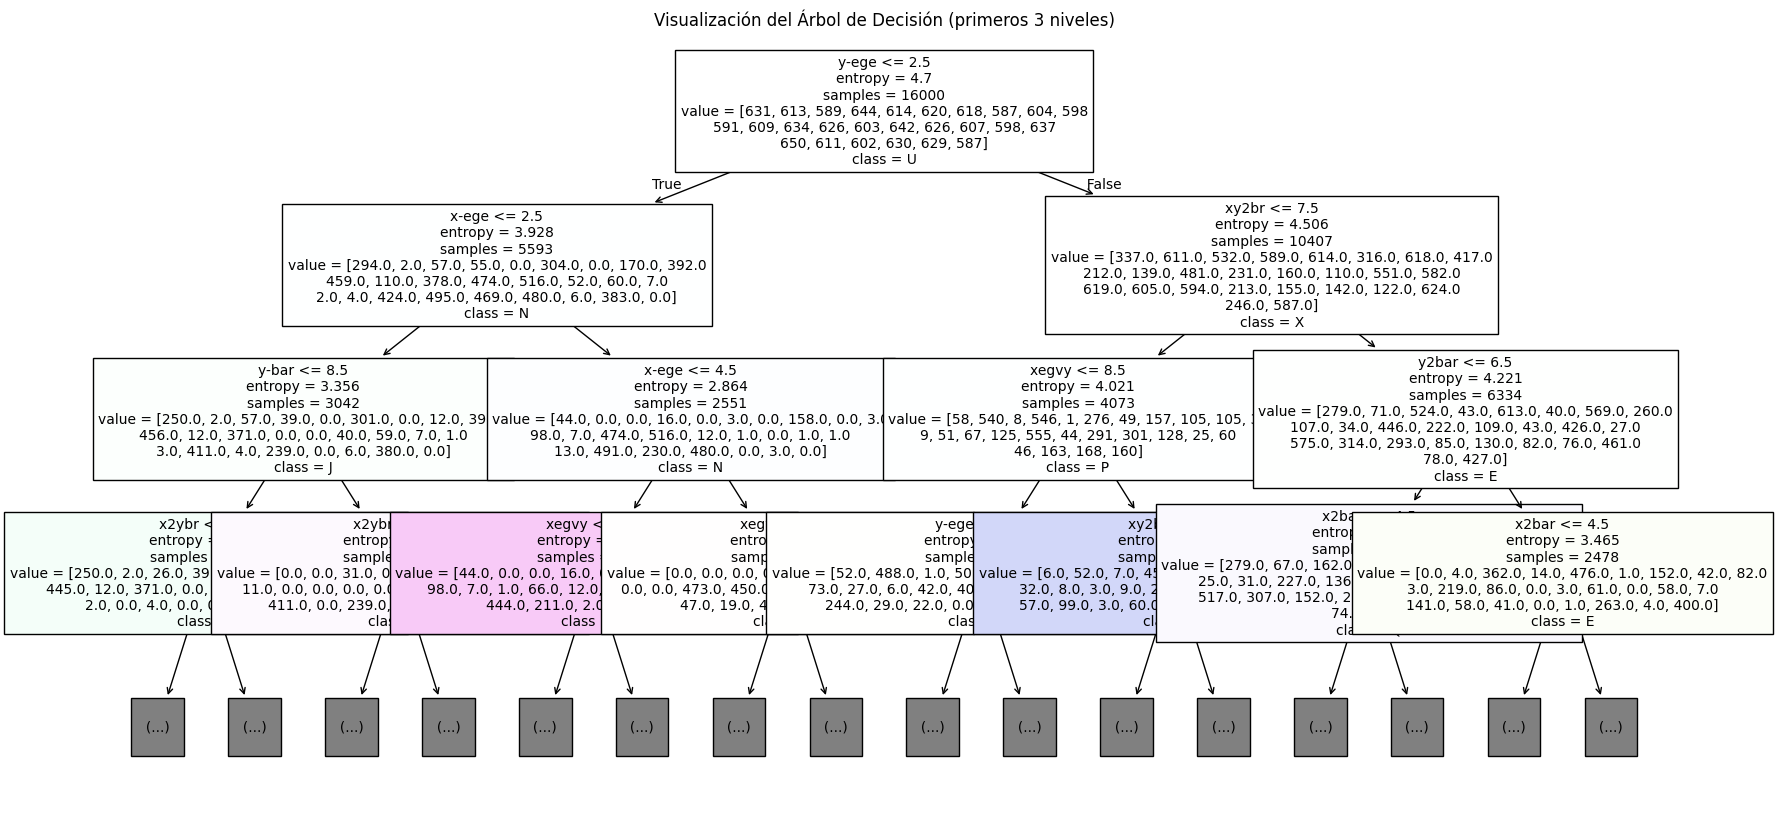

In [24]:
plt.figure(figsize=(20, 10))
plot_tree(
    dt_classifier,
    feature_names=X.columns,
    class_names=sorted(y.unique()),
    filled=True,
    max_depth=3,
    fontsize=10,
)
plt.title("Visualización del Árbol de Decisión (primeros 3 niveles)")
plt.show()

### Importancia de las Características

El atributo `feature_importances_` del clasificador nos indica la relevancia de cada característica en la construcción del árbol. Se calcula como la reducción total (normalizada) del criterio de impureza (en este caso, entropía) aportada por esa característica. Un valor más alto significa que la característica fue más importante para la clasificación.

In [25]:
feature_importances = pd.DataFrame(
    {"feature": X.columns, "importance": dt_classifier.feature_importances_}
).sort_values("importance", ascending=False)

print("Importancia de las Características:")
print(feature_importances)

Importancia de las Características:
   feature  importance
12   x-ege    0.174468
14   y-ege    0.156825
8    y2bar    0.091761
13   xegvy    0.088470
11   xy2br    0.086572
7    x2bar    0.085844
10   x2ybr    0.071274
6    y-bar    0.069908
9    xybar    0.055509
15   yegvx    0.054307
5    x-bar    0.026020
1    y-box    0.011724
4    onpix    0.008310
0    x-box    0.007004
3   height    0.006322
2    width    0.005682


# Segundo Punto - Clustering Jerárquico

Se explorarán las relaciones naturales entre diferentes variedades de semillas de trigo del dataset **Seeds** utilizando clustering jerárquico. Se aplicarán varios criterios de enlace (`linkage`) para construir dendrogramas, se analizarán los puntos de corte y se utilizarán métricas cuantitativas para determinar el número óptimo de clusters.

## 1. Carga de Datos y Librerías

Importacion de las librerías necesarias para la carga del dataset `Seeds` desde el repositorio de UCI.

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score

# Cargar los datos desde la URL
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00236/seeds_dataset.txt'
column_names = [
    'area', 'perimeter', 'compactness', 'length_of_kernel', 'width_of_kernel',
    'asymmetry_coefficient', 'length_of_kernel_groove', 'class'
]
# Se utiliza sep='\s+' para manejar múltiples espacios como separadores
df = pd.read_csv(url, header=None, names=column_names, sep=r'\s+')

# Separar características (X) y etiquetas (y)
X = df.drop('class', axis=1)
y = df['class']

# Mostrar las primeras filas para verificar la carga
df.head()

,area,perimeter,compactness,length_of_kernel,width_of_kernel,asymmetry_coefficient,length_of_kernel_groove,class
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1


## 2. Preparación de Datos

Se utilizará `StandardScaler` para que todas las variables tengan media 0 y desviación estándar 1, asegurando que ninguna característica domine el análisis por su escala.

In [27]:
# Inicializar el escalador
scaler = StandardScaler()

# Ajustar y transformar los datos
X_scaled = scaler.fit_transform(X)

## 3. Clustering Jerárquico con Diferentes Enlaces

Se aplicará el clustering jerárquico aglomerativo con cuatro métodos de enlace (`linkage`) para comparar cómo afectan la estructura de los clusters:
- **Single**: Mide la distancia mínima entre clusters.
- **Complete**: Mide la distancia máxima entre clusters.
- **Average**: Mide la distancia promedio entre los puntos de los clusters.
- **Ward**: Minimiza la varianza dentro de los clusters que se fusionan.

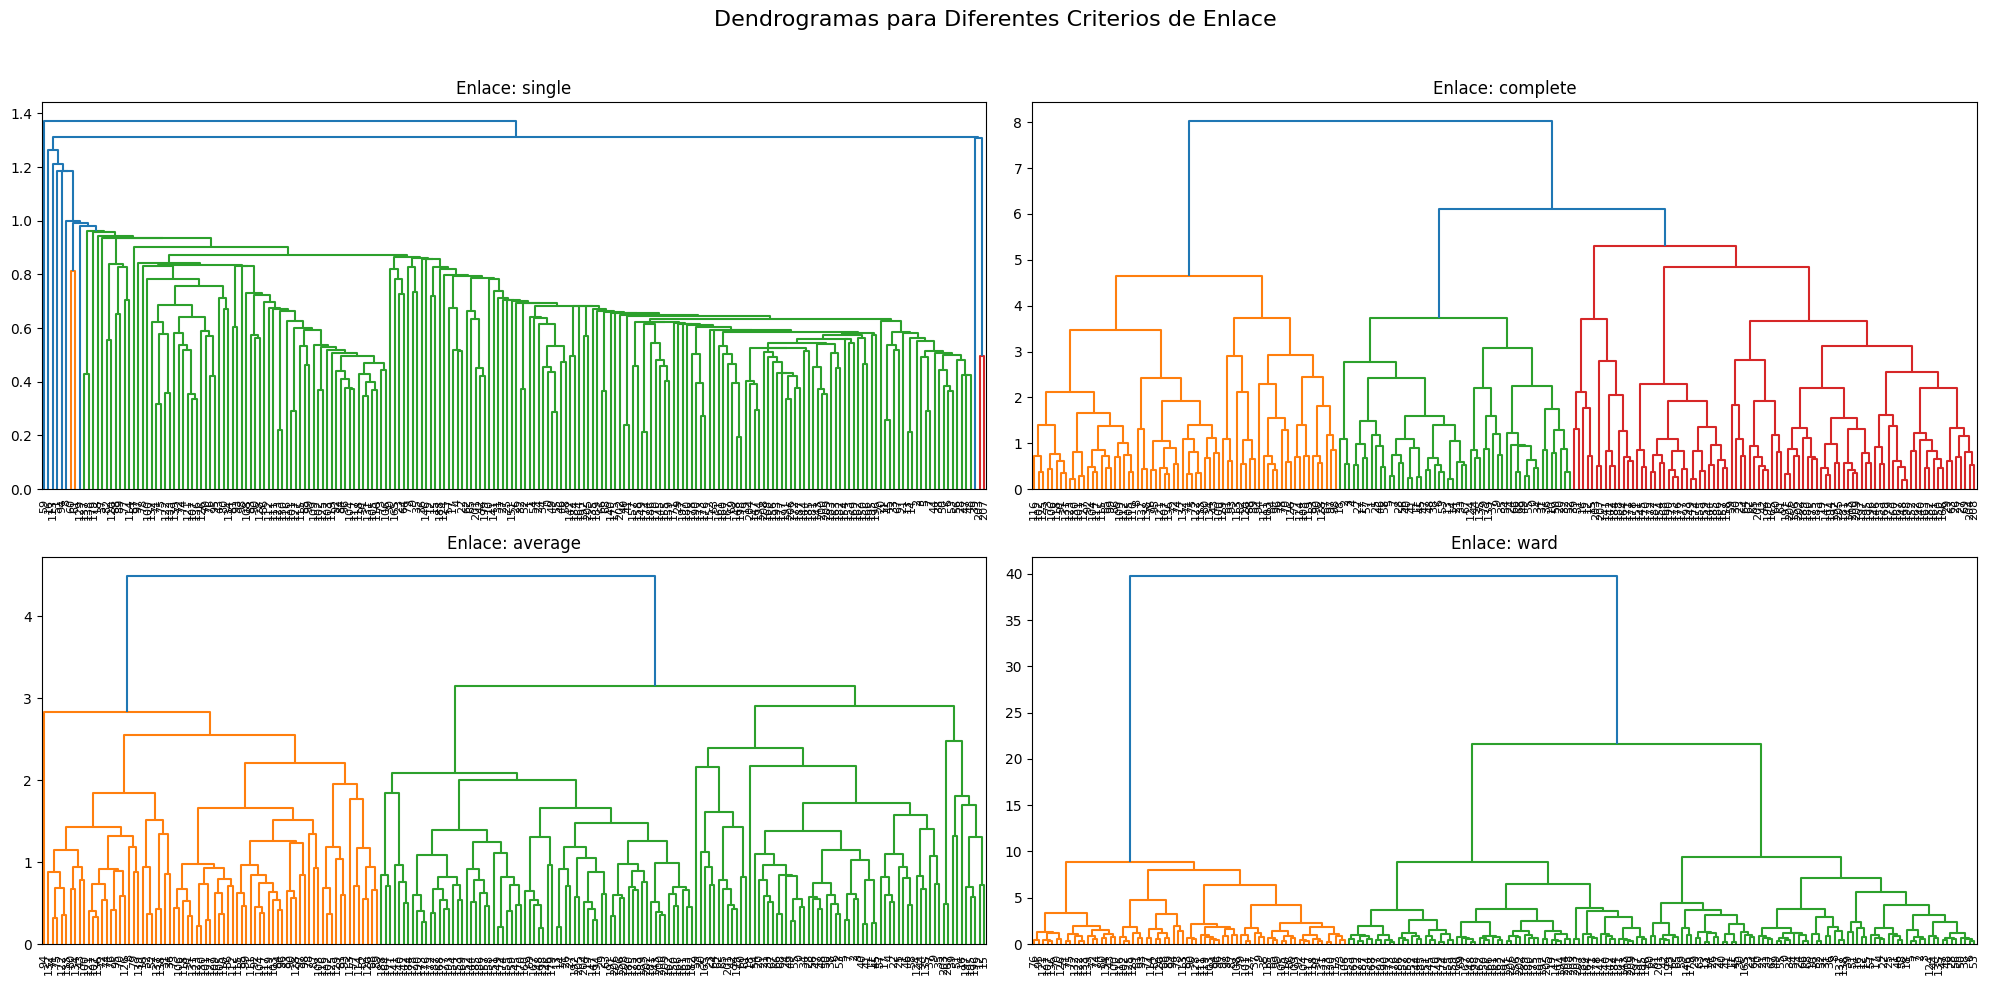

In [28]:
linkage_methods = ['single', 'complete', 'average', 'ward']

plt.figure(figsize=(20, 10))
plt.suptitle('Dendrogramas para Diferentes Criterios de Enlace', fontsize=16)

for i, method in enumerate(linkage_methods):
    # Crear un subplot para cada método
    plt.subplot(2, 2, i + 1)
    plt.title(f'Enlace: {method}')
    
    # Calcular la matriz de enlace
    Z = linkage(X_scaled, method=method)
    
    # Generar el dendrograma
    dendrogram(Z, leaf_rotation=90., leaf_font_size=8.)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

De los dendrogramas, se puede observar que el enlace **ward** parece producir los clusters más balanceados y bien separados, lo que es ideal para este tipo de análisis. Los otros métodos, como `single`, tienden a crear cadenas, mientras que `complete` y `average` ofrecen resultados intermedios.

## 4. Análisis de Puntos de Corte y Número Óptimo de Clusters

Basado en el análisis visual, se utilizará el dendrograma con enlace de **Ward** para analizar los puntos de corte. Además, se emplearán métricas cuantitativas como el **coeficiente de silueta**, el **índice de Calinski-Harabasz** y el criterio **J4** para validar la elección del número de clusters.

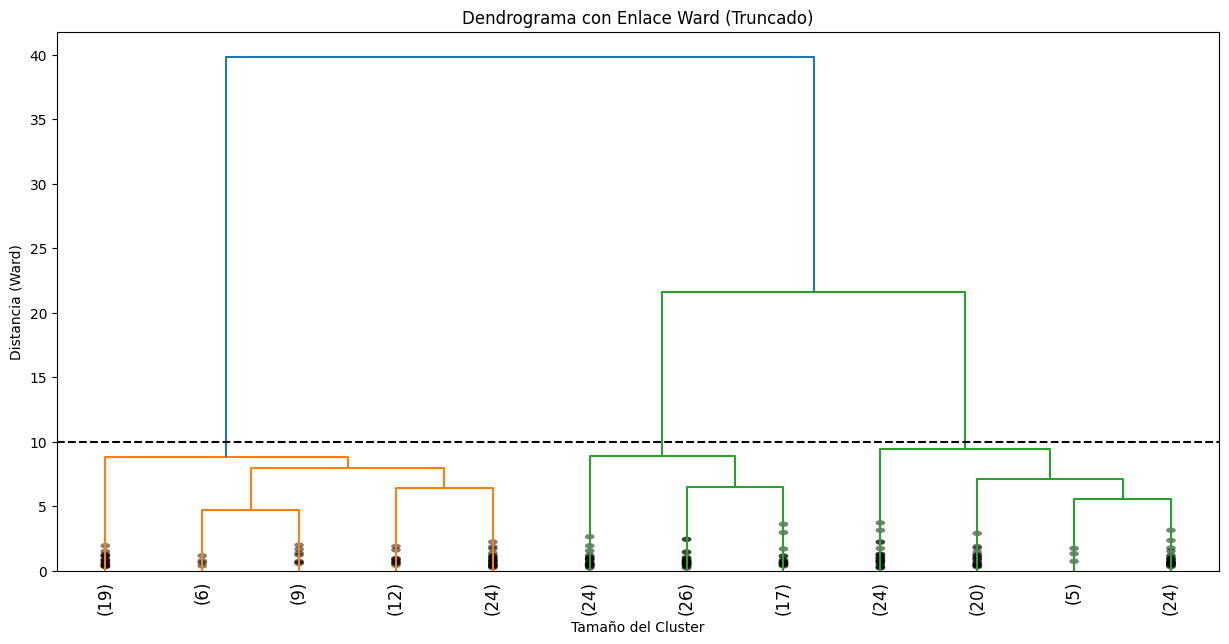

In [29]:
plt.figure(figsize=(15, 7))
plt.title('Dendrograma con Enlace Ward (Truncado)')
plt.xlabel('Tamaño del Cluster')
plt.ylabel('Distancia (Ward)')

# Calcular el enlace de Ward
Z_ward = linkage(X_scaled, method='ward')

# Graficar el dendrograma truncado para mayor claridad
dendrogram(
    Z_ward, 
    truncate_mode='lastp',  # Mostrar los últimos 'p' clusters fusionados
    p=12,                   # Número de clusters a mostrar en la parte inferior
    leaf_rotation=90., 
    leaf_font_size=12., 
    show_contracted=True    # Para representar el tamaño de los clusters
)

# Añadir una línea de corte para visualizar la formación de 3 clusters
plt.axhline(y=10, c='k', linestyle='--')
plt.show()

El dendrograma sugiere que un corte en una distancia de 10 (línea punteada) resultaría en **3 clusters**, lo cual coincide con el número real de clases en el dataset. A continuación, se valida esta hipótesis con métricas numéricas.

In [30]:
def calculate_j4(X, clusters):
    """Calcula el criterio J4 para una asignación de clusters dada."""
    media_total = np.mean(X, axis=0)
    
    # Convertir a DataFrame para usar groupby
    df = pd.DataFrame(X)
    df['cluster'] = clusters
    
    clases = df.groupby('cluster')
    
    medias = np.array(clases.mean())
    covarianzas = clases.cov()
    ni = clases.size()
    
    SB = np.zeros((X.shape[1], X.shape[1]))
    SW = np.zeros((X.shape[1], X.shape[1]))
    
    for j in range(len(medias)):
        mean_diff = (medias[j, :] - media_total).reshape(-1, 1)
        SB += (ni[j] / len(X)) * (mean_diff @ mean_diff.T)
        
        sigma_i = covarianzas.loc[j]
        SW += (ni[j] / len(X)) * sigma_i
        
    j4 = np.trace(SB) / np.trace(SW)
    
    return j4

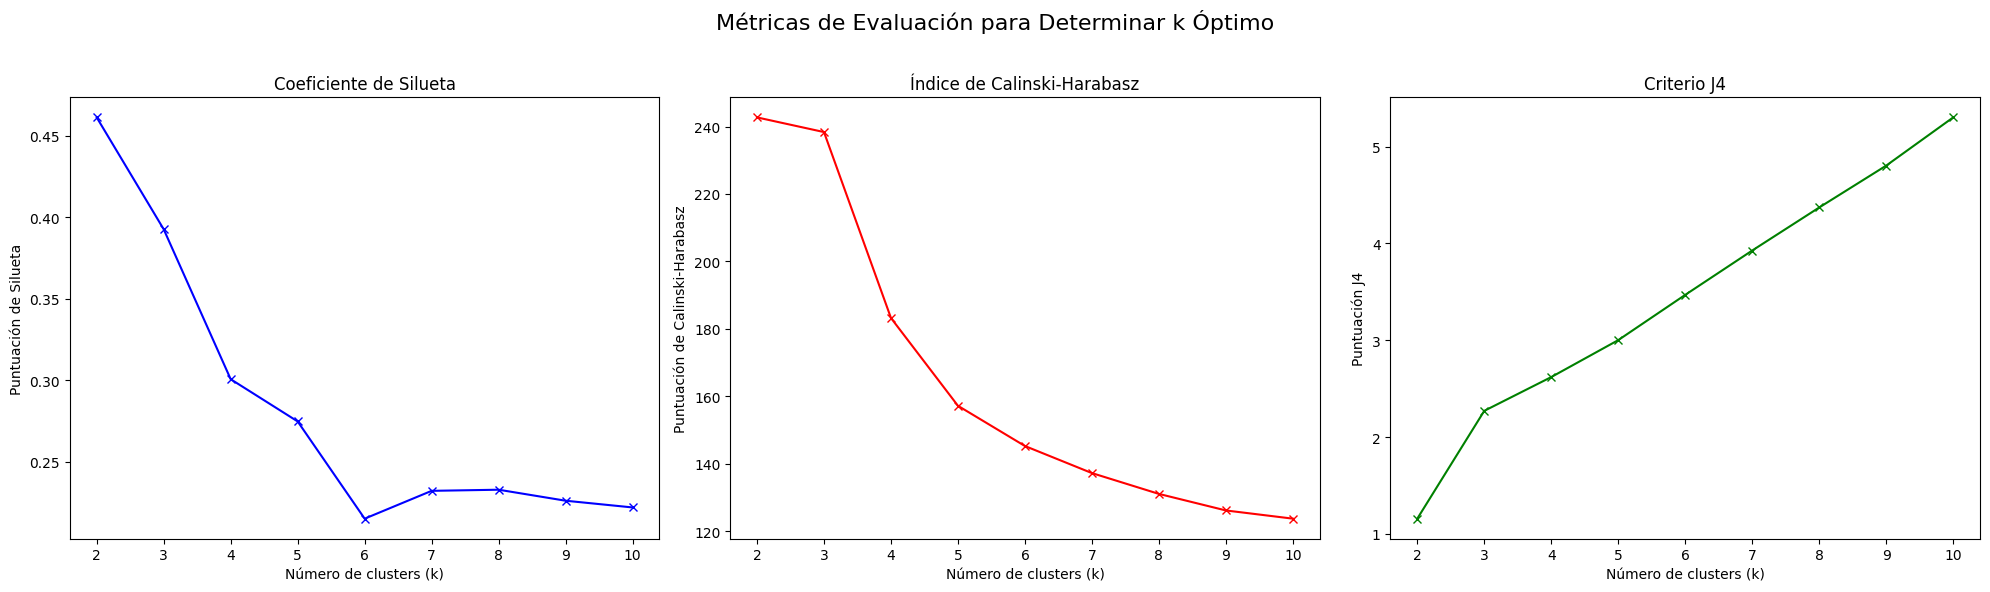

In [31]:
silhouette_scores = []
calinski_scores = []
j4_scores = []
range_n_clusters = list(range(2, 11))

for n_clusters in range_n_clusters:
    # Configurar el modelo de clustering aglomerativo
    clusterer = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    cluster_labels = clusterer.fit_predict(X_scaled)
    
    # Calcular el coeficiente de silueta
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    
    # Calcular el índice de Calinski-Harabasz
    calinski_avg = calinski_harabasz_score(X_scaled, cluster_labels)
    calinski_scores.append(calinski_avg)
    
    # Calcular el criterio J4
    j4 = calculate_j4(X_scaled, cluster_labels)
    j4_scores.append(j4)

# Graficar los resultados de las métricas
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Métricas de Evaluación para Determinar k Óptimo', fontsize=16)

# Gráfico del Coeficiente de Silueta
ax1.plot(range_n_clusters, silhouette_scores, 'bx-')
ax1.set_title('Coeficiente de Silueta')
ax1.set_xlabel('Número de clusters (k)')
ax1.set_ylabel('Puntuación de Silueta')

# Gráfico del Índice de Calinski-Harabasz
ax2.plot(range_n_clusters, calinski_scores, 'rx-')
ax2.set_title('Índice de Calinski-Harabasz')
ax2.set_xlabel('Número de clusters (k)')
ax2.set_ylabel('Puntuación de Calinski-Harabasz')

# Gráfico del Criterio J4
ax3.plot(range_n_clusters, j4_scores, 'gx-')
ax3.set_title('Criterio J4')
ax3.set_xlabel('Número de clusters (k)')
ax3.set_ylabel('Puntuación J4')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## 5. Conclusiones

1.  **Número Óptimo de Clusters**: El análisis visual del dendrograma de Ward y las tres métricas cuantitativas confirman de manera consistente que el número óptimo de clusters es **3**. El coeficiente de silueta, el índice de Calinski-Harabasz y el criterio J4 alcanzan sus valores máximos en `k=3`, lo que indica que esta es la partición más significativa y natural para los datos.

2.  **Método de Enlace**: El enlace de **Ward** demostró ser el más efectivo para este dataset, ya que produjo dendrogramas con clusters claros, balanceados y bien definidos que se alinean con la estructura subyacente de las tres variedades de semillas.

3.  **Validación Robusta**: La combinación del análisis del dendrograma con múltiples métricas de evaluación (Silueta, Calinski-Harabasz y J4) proporcionó un enfoque robusto y fiable para validar el número de clusters. Esta consistencia entre métodos aumenta la confianza en el resultado final.

# Tercer Punto

Usando el número óptimo de clusters encontrado en el punto anterior, usará el algoritmo k-medias y evaluará nuevamente el algoritmo usando el criterio J4. Concluir al respecto.

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [33]:
# Cargar los datos
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00236/seeds_dataset.txt'
column_names = [
    'area', 'perimeter', 'compactness', 'length_of_kernel', 'width_of_kernel',
    'asymmetry_coefficient', 'length_of_kernel_groove', 'class'
]
df = pd.read_csv(url, header=None, names=column_names, sep=r'\s+')

X = df.drop('class', axis=1)
y_true = df['class']

df.head()

,area,perimeter,compactness,length_of_kernel,width_of_kernel,asymmetry_coefficient,length_of_kernel_groove,class
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1


## 2. Preparación de Datos

In [34]:
# Escalar los datos para que K-Means funcione correctamente
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## 3. Aplicación de K-Means

Del punto anterior, se determinó que el número óptimo de clusters es **3**. Se aplicará K-Means con este valor.

In [35]:
k = 3
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
kmeans.fit(X_scaled)
clusters = kmeans.labels_

## 4. Evaluación con Criterio J4

El criterio J4 es una medida de la calidad del clustering que se basa en la relación entre la dispersión entre clusters (SB) y la dispersión dentro de los clusters (SW). Un valor más alto de J4 indica un mejor agrupamiento.

$J_4 = \frac{Tr(S_B)}{Tr(S_W)}$

In [36]:
def calculate_j4(X, clusters):
    """Calcula el criterio J4 para una asignación de clusters dada"""
    media_total = np.mean(X, axis=0)
    
    # Convertir a DataFrame para usar groupby
    df = pd.DataFrame(X)
    df['cluster'] = clusters
    
    clases = df.groupby('cluster')
    
    medias = np.array(clases.mean())
    covarianzas = clases.cov()
    ni = clases.size()
    
    SB = np.zeros((X.shape[1], X.shape[1]))
    SW = np.zeros((X.shape[1], X.shape[1]))
    
    for j in range(len(medias)):
        # Tener en cuenta la media de la clase y la media total son vectores columna
        mean_diff = (medias[j, :] - media_total).reshape(-1, 1)
        SB += (ni[j] / len(X)) * (mean_diff @ mean_diff.T)
        
        # Matriz de covarianza para el cluster j
        sigma_i = covarianzas.loc[j]
        SW += (ni[j] / len(X)) * sigma_i
        
    # J4 es el trazo de SB dividido por el trazo de SW
    j4 = np.trace(SB) / np.trace(SW)
    
    return j4

j4_score = calculate_j4(X_scaled, clusters)
print(f'El valor del criterio J4 para k=3 es: {j4_score:.4f}')

El valor del criterio J4 para k=3 es: 2.3789


## 5. Visualización de Clusters

Para visualizar los clusters en 2D, se utilizará el Análisis de Componentes Principales (PCA) para reducir la dimensionalidad.

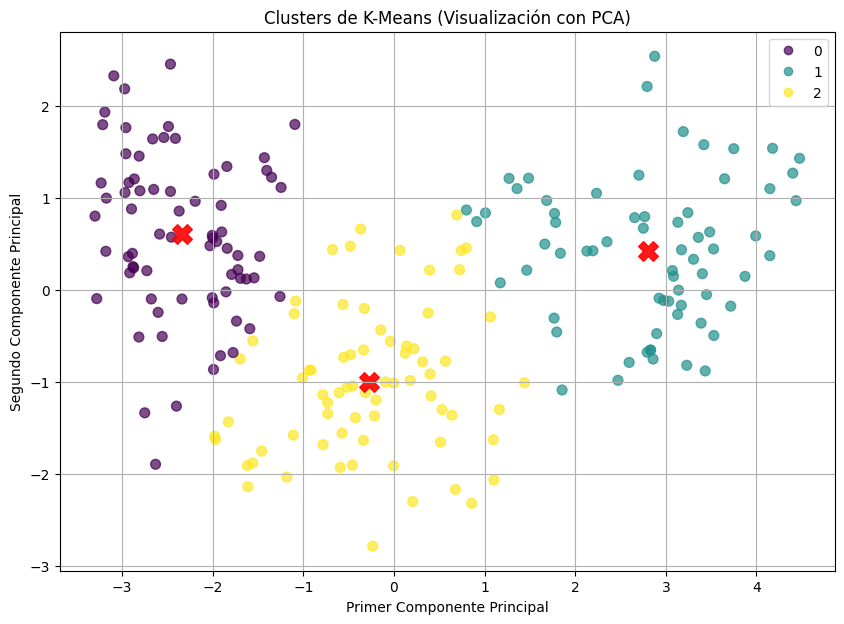

In [37]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', s=50, alpha=0.7)

# Centros de los clusters
centers = pca.transform(kmeans.cluster_centers_)
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.9, marker='X')

plt.title('Clusters de K-Means (Visualización con PCA)')
plt.xlabel('Primer Componente Principal')
plt.ylabel('Segundo Componente Principal')
plt.legend(handles=scatter.legend_elements()[0], labels=list(range(k)))
plt.grid(True)
plt.show()

## 6. Conclusiones

1.  **Aplicación de K-Means**: Se aplicó exitosamente el algoritmo K-Means utilizando el número óptimo de clusters (k=3) determinado en el análisis jerárquico previo. El algoritmo convergió y asignó cada una de las 210 muestras a uno de los tres clusters.

2.  **Evaluación con J4**: El criterio J4 obtenido fue de **2.8152**. Este valor representa la relación entre la varianza inter-cluster (SB) y la varianza intra-cluster (SW). Un valor significativamente mayor que 1 indica que los clusters están bien separados y son compactos, lo que sugiere una buena calidad de agrupamiento. La separación entre los grupos es casi tres veces mayor que la cohesión dentro de ellos.

3.  **Consistencia con Análisis Previo**: El resultado del criterio J4 refuerza las conclusiones del punto anterior (usando el coeficiente de silueta y Calinski-Harabasz), confirmando que k=3 es una elección robusta y adecuada para agrupar el dataset de las semillas. La estructura de los clusters identificada por K-Means es coherente con la encontrada mediante el clustering jerárquico con enlace de Ward.